__INSTALL SPACY__

In [ ]:
! pip install -U spacy -q


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


combine json files

In [ ]:
!python -m spacy info

2024-01-14 10:45:30.766794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 10:45:30.766878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 10:45:30.769774: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 10:45:30.783021: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-14 10:45:32.233767: W tensorflow/compiler/tf2

Import spacy english model.

In [ ]:
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

nlp = spacy.blank("en") # load a new spacy model
db = DocBin() # create a DocBin object

__IMPORT TRAINING DATA.__

In [ ]:
import json
f = open('test-train-data/comb-annotations.json')
TRAIN_DATA = json.load(f)

In [ ]:
print(TRAIN_DATA)

{'classes': ['COMMON NAME', 'COMPOSITION NAME'], 'annotations': [['Image 1: Acid-labletsBP MEFTAL-500 Each Uncoated Tablet Contains: 500 mg Mefenamic Acid IP MET-EETTEO Excipients q.s. Dosage:As prescribed by the Physician Store protected from light & moisture at a temperature not exceeding 30C 205208 Keep out of reach of children. Registered Trademark BLUE MADE IN INDIA BY BLUE CROSS LABORATORIES PVTLTD L-17.VERNA INDUSTRIAL ESTATE VERNA.GOA403 722 CROSS Regd OPeninsula Chambers.G.K Mag Mumbai400 013. Rx Mefenamic AcidTablets:BP CCAo LOROURS MEFTAL-500 ', {'entities': [[24, 34, 'COMMON NAME'], [66, 90, 'COMPOSITION NAME']]}], ['Image 2: SCHEDULE H DRUG Warning To be Anti-inflammatory- Analgesic sold by retail on the prescription of a Registered MedicalPractitioner only Composition: Each uncoated tablet contains: "Bronchospasm may be precipitated in Ibuproten IP 400 mg patients suffering from or with a previous ParacetamolIP 325 mg history ot bronchial asthma.Ibuprofen Excipients: q.s 

__CONVERT THE TRAINING DATA INTO SPACY FORMAT.__

In [ ]:
for text, annot in tqdm(TRAIN_DATA['annotations']):
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in annot["entities"]:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    doc.ents = ents
    db.add(doc)

db.to_disk("./test-train-data/training_data.spacy") # save the docbin object

100%|████████████████████████████████████████| 336/336 [00:01<00:00, 207.73it/s]


__CREATE A CONFIGURATION FILE.__

In [ ]:
! python3 -m spacy init config config.cfg --lang en --pipeline ner --optimize efficiency

⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


__TRAIN THE MODEL.__

In [ ]:
! python3 -m spacy train config.cfg --output ./ --paths.train ./test-train-data/training_data.spacy --paths.dev ./test-train-data/training_data.spacy

ℹ Saving to output directory: .
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     40.50    0.00    0.00    0.00    0.00
  1     200        285.89   1864.53   11.54   13.07   10.34    0.12
  2     400       1633.44   1724.78   34.53   34.67   34.39    0.35
  3     600        319.27    928.61   68.64   70.59   66.80    0.69
  5     800        168.34    702.79   82.04   79.37   84.89    0.82
  7    1000        271.72    525.27   85.89   89.80   82.31    0.86
  9    1200        343.87    441.28   94.99   95.76   94.23    0.95
 12    1400        368.01    354.31   94.37   95.52   93.24    0.94
 16    1600        263.29    303.07 

__LOAD THE TRAINED MODEL.__


In [ ]:
nlp_ner = spacy.load("models/model-best")

__LOAD TRAINING EXAMPLE FROM OCR.__

In [ ]:
doc = nlp_ner(''' Rosuvastatin Tablets IP 10 mg CAUmON:Nat to be soldo 2023 TAXES Turbovas-10 retailwithout the prescriptior  Regisiered Medical Prad Each film-coated toblet contains: Mfg.Lic.No.:M/600/2012 Dosage:As directed by Rosuvastatin Caicium ip the Physician Made in India by: equivalent to MICROLABS LAMITED Rosuvastatin 10 mg Store in a dry & dark place Mamoog.Namthang Road Colours:Red Oxide of Iron & at a temperature SouthSikkm-737132 not exceeding 30c RegdTrace Mark Titanium Dioxide IP Turbovas-10 Turbovas. Cararpet Rosuvastatin Tablets P 10 mg NNot to be s Turbovas-10 out the pre Each film-coate osage Rosuvastatin Calcium Physician equivalent to Store ina &dark place CRO LABS LIMTEC Rosuvastatin 10 mg Mamring.Namthang Colours: Red Oxide f ron & at a teoaaroture South Sikkim-737 1 not excesdg 30C. Titanium Dioxide Regd.Trade M Turbovas-10 Turbovas- Tefar ''')

__DISPLAY THE OUTPUT.__

In [ ]:
spacy.displacy.render(doc, style="ent", jupyter=True)

__LOAD THE TEST DATA.__

In [ ]:

f = open('test-train-data/test.json')
TRAIN_DATA = json.load(f)
print(TRAIN_DATA)

{'classes': ['COMPOSITION NAME', 'COMMON NAME'], 'annotations': [['Image 351: Rx Propranolol Tablets I.P. Inderal*20 GTIN:18904145935595 Imported&Distributed by in Nepal EXP250531 Gunjeshwari B.NO:INZ23014 Pharma Adarsh Nagar-13 S.NO:21102721711443 Birganj,Parsa Email:gpadmn@gmail.com Exim Code:3005153140148NP 20 mg 20 x2 x 15 Tablets ', {'entities': [[14, 33, 'COMMON NAME']]}], ['Image 352: Rx 120 mg 100 Tablets ControlledRelease Tablets of DiltiazemHydrochloride DILCONTIN XL120 CONTINUS controlled release system f0 UNDIPHARMA ', {'entities': [[33, 84, 'COMMON NAME']]}], ['Image 353: Rx 120 mg 100 Tablets ControlledRelease Tablets of DiltiazemHydrochloride DILCONTIN XL120 CONTINUS controlled release system f0 UNDIPHARMA ', {'entities': [[33, 84, 'COMMON NAME']]}], ['Image 354: Amlodipine& Mig.Lic.No916541 .osartan Potassium Tablets IP M.R.P15TABS.Rs.187.50 MFD.JUL.23EXP.JUN.25 B.No.165286 Mylod-L omsons-uCr Ench ljlm-coated iabletcontains Amiodipine Besylate IP equivalent to Amlodipin

CONVERT TEST DATA INTO SPACY FORMAT.

In [ ]:
for text, annot in tqdm(TRAIN_DATA['annotations']):
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in annot["entities"]:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    doc.ents = ents
    db.add(doc)

db.to_disk("./test_data.spacy")

100%|██████████████████████████████████████████| 97/97 [00:00<00:00, 293.62it/s]


__EVALUATE THE TEST SET.__

In [ ]:
!python3 -m spacy evaluate models/model-last ./test_data.spacy

ℹ Using CPU

================================== Results ==================================

TOK     100.00
NER P   95.64 
NER R   84.87 
NER F   89.94 
SPEED   12525 


=============================== NER (per type) ===============================

                       P       R       F
COMMON NAME        96.26   81.32   88.16
COMPOSITION NAME   94.87   89.88   92.31



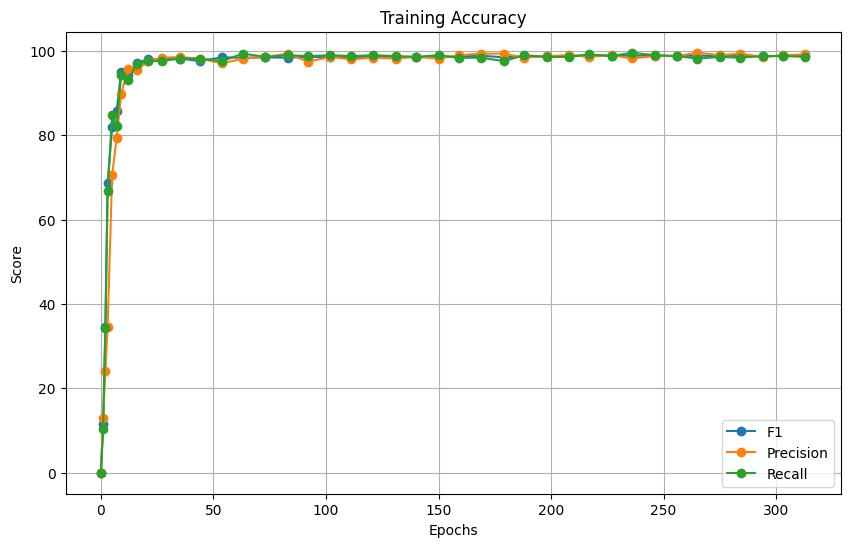

In [1]:
import matplotlib.pyplot as plt

def plot_metrics(epochs, f1_values, precision_values, recall_values):
    plt.figure(figsize=(10, 6))

    # Plot F1
    plt.plot(epochs, f1_values, label='F1', marker='o')

    # Plot Precision
    plt.plot(epochs, precision_values, label='Precision', marker='o')

    # Plot Recall
    plt.plot(epochs, recall_values, label='Recall', marker='o')

    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Training Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example values (replace these with your actual data)
epochs = [0, 1, 2, 3, 5, 7, 9, 12, 16, 21, 27, 35, 44, 54, 63, 73, 83, 92, 102, 111, 121, 131, 140, 150, 159, 169, 179, 188, 198, 208, 217, 227, 236, 246, 256, 265, 275, 284, 294, 303, 313]
f1_values = [0.00, 11.54, 34.53, 68.64, 82.04, 85.89, 94.99, 94.37, 97.21, 98.00, 98.10, 98.21, 97.63, 98.51, 98.41, 98.50, 98.43, 98.61, 98.52, 98.61, 98.61, 98.61, 98.61, 98.61, 98.70, 98.90, 98.50, 98.71, 98.71, 98.90, 98.91, 98.91, 98.91, 98.91, 98.81, 98.90, 98.80, 98.90, 98.71, 98.91, 98.90]
recall_values = [0.00, 10.34, 34.39, 66.80, 84.89, 82.31, 94.23, 93.24, 96.82, 97.61, 97.61, 98.21, 98.21, 97.61, 99.40, 98.61, 99.01, 98.81, 99.01, 98.81, 99.01, 98.81, 98.61, 99.01, 98.41, 98.41, 97.61, 99.01, 98.61, 98.61, 99.20, 98.81, 99.60, 99.01, 98.81, 98.21, 98.61, 98.41, 98.81, 98.81, 98.61]
precision_values = [0.00, 13.07, 24.21 , 34.67, 70.59, 79.37, 89.80, 95.76, 95.52, 97.60, 98.40, 98.59, 98.21, 97.05, 98.22, 98.60, 99.39, 97.47, 98.61, 98.03, 98.42, 98.22, 98.61, 98.22, 99.00, 99.40, 99.39, 98.42, 98.80, 99.00, 98.62, 99.00, 98.24, 98.81, 98.81, 99.60, 99.00, 99.40, 98.61, 99.00, 99.20]

# Call the function to plot the metrics
plot_metrics(epochs, f1_values, precision_values, recall_values)


Length of y_true: 359
Length of y_pred: 359
Length of tp_list: 283
Length of fn_list: 65
Length of fp_list: 11
NER Precision: 96.26%
NER Recall: 81.32%
NER F1 Score: 88.16%


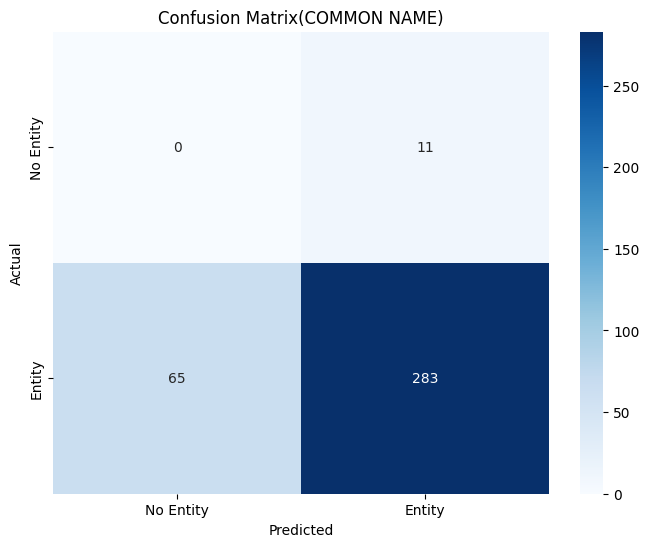

In [ ]:
import spacy
from spacy.tokens import DocBin
from spacy.training.example import Example
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

# Load your trained spaCy NER model
nlp = spacy.load("models/model-last")

# Load test data from a .spacy file
test_data_path = "test_data.spacy"  # Replace with the actual path to your test data
doc_bin = DocBin().from_disk(test_data_path)
test_data = list(doc_bin.get_docs(nlp.vocab))

# Initialize lists for true positives, false positives, and false negatives
tp_list, fp_list, fn_list = [], [], []

# Initialize lists for y_true and y_pred
y_true_list, y_pred_list = [], []

# Specify the entity label you want to evaluate (e.g., "COMMON NAME")
eval_entity_label = "COMMON NAME"

# Iterate through the test data
for doc in test_data:
    gold_dict = {"text": doc.text, "entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}
    gold = Example.from_dict(nlp.make_doc(doc.text), gold_dict).reference  # Access gold annotations via .reference

    # Get predicted entities from the model
    doc_pred = nlp(doc.text)
    pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc_pred.ents]

    # Initialize y_true and y_pred for the current document
    y_true, y_pred = [], []

    # Update true positives, false positives, and false negatives
    for span in gold.ents:
        if span.label_ == eval_entity_label:
            if (span.start_char, span.end_char, span.label_) in pred_entities:
                tp_list.append(1)
                y_true.append(1)
                y_pred.append(1)
            else:
                fn_list.append(1)
                y_true.append(1)
                y_pred.append(0)

    for ent in pred_entities:
        if ent[2] == eval_entity_label:
            if ent not in [(span.start_char, span.end_char, span.label_) for span in gold.ents]:
                fp_list.append(1)
                y_true.append(0)
                y_pred.append(1)

    # Append y_true and y_pred to the lists
    y_true_list.extend(y_true)
    y_pred_list.extend(y_pred)

# Ensure that y_true and y_pred have the same length
y_true = y_true_list
y_pred = y_pred_list

# Print the lengths of y_true and y_pred
print("Length of y_true:", len(y_true))
print("Length of y_pred:", len(y_pred))

# Print the lengths of tp_list, fn_list, fp_list
print("Length of tp_list:", len(tp_list))
print("Length of fn_list:", len(fn_list))
print("Length of fp_list:", len(fp_list))

# Calculate Precision, Recall, and F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

# Print Precision, Recall, and F1 Score
print(f"NER Precision: {precision * 100:.2f}%")
print(f"NER Recall: {recall * 100:.2f}%")
print(f"NER F1 Score: {f1 * 100:.2f}%")# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Entity', 'Entity'],
            yticklabels=['No Entity', 'Entity'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix(COMMON NAME)')
plt.show()


Length of y_true: 259
Length of y_pred: 259
Length of tp_list: 222
Length of fn_list: 25
Length of fp_list: 12
NER Precision: 94.87%
NER Recall: 89.88%
NER F1 Score: 92.31%


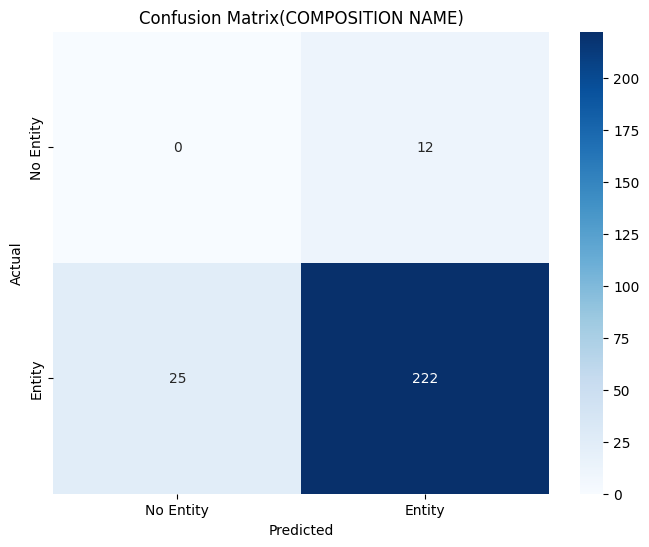

In [ ]:
import spacy
from spacy.tokens import DocBin
from spacy.training.example import Example
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

# Load your trained spaCy NER model
nlp = spacy.load("models/model-last")

# Load test data from a .spacy file
test_data_path = "test_data.spacy"  # Replace with the actual path to your test data
doc_bin = DocBin().from_disk(test_data_path)
test_data = list(doc_bin.get_docs(nlp.vocab))

# Initialize lists for true positives, false positives, and false negatives
tp_list, fp_list, fn_list = [], [], []

# Initialize lists for y_true and y_pred
y_true_list, y_pred_list = [], []

# Specify the entity label you want to evaluate (e.g., "COMMON NAME")
eval_entity_label = "COMPOSITION NAME"

# Iterate through the test data
for doc in test_data:
    gold_dict = {"text": doc.text, "entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}
    gold = Example.from_dict(nlp.make_doc(doc.text), gold_dict).reference  # Access gold annotations via .reference

    # Get predicted entities from the model
    doc_pred = nlp(doc.text)
    pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc_pred.ents]

    # Initialize y_true and y_pred for the current document
    y_true, y_pred = [], []

    # Update true positives, false positives, and false negatives
    for span in gold.ents:
        if span.label_ == eval_entity_label:
            if (span.start_char, span.end_char, span.label_) in pred_entities:
                tp_list.append(1)
                y_true.append(1)
                y_pred.append(1)
            else:
                fn_list.append(1)
                y_true.append(1)
                y_pred.append(0)

    for ent in pred_entities:
        if ent[2] == eval_entity_label:
            if ent not in [(span.start_char, span.end_char, span.label_) for span in gold.ents]:
                fp_list.append(1)
                y_true.append(0)
                y_pred.append(1)

    # Append y_true and y_pred to the lists
    y_true_list.extend(y_true)
    y_pred_list.extend(y_pred)

# Ensure that y_true and y_pred have the same length
y_true = y_true_list
y_pred = y_pred_list

# Print the lengths of y_true and y_pred
print("Length of y_true:", len(y_true))
print("Length of y_pred:", len(y_pred))

# Print the lengths of tp_list, fn_list, fp_list
print("Length of tp_list:", len(tp_list))
print("Length of fn_list:", len(fn_list))
print("Length of fp_list:", len(fp_list))

# Calculate Precision, Recall, and F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

# Print Precision, Recall, and F1 Score
print(f"NER Precision: {precision * 100:.2f}%")
print(f"NER Recall: {recall * 100:.2f}%")
print(f"NER F1 Score: {f1 * 100:.2f}%")
# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Entity', 'Entity'],
            yticklabels=['No Entity', 'Entity'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix(COMPOSITION NAME)')
plt.show()
